In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform, loguniform

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('darkgrid') # just getting this out of the way early so the graphs look nice

In [3]:
df = pd.read_csv('../data/dataframes/epi_cleaned.csv')

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

Creating a df of just the 2020 scores to get the current top and bottom performers on EPI:

In [5]:
epi_2020 = df[df['year'] == 2020]

In [6]:
epi_2020.reset_index(inplace=True)

In [7]:
#function to return a list of the countries that are at the top or bottom of EPI performance
def country_list(num_countries, top=True):
    if top:
        index_list_high = epi_2020['Environmental Performance Index'].sort_values(ascending=False).head(num_countries).index
        top_country_list = []
        for index in index_list_high:
            top_country_list.append(epi_2020.loc[index, 'country_name'])
        return top_country_list
    else:
        index_list_low = epi_2020['Environmental Performance Index'].sort_values(ascending=False).tail(num_countries).index
        bot_country_list = []
        for index in index_list_low:
            bot_country_list.append(epi_2020.loc[index, 'country_name'])
        return bot_country_list

# line reg:

Pre-computed variables that were in the data set, which we dropped because they are aggregated data, which has a lot of colinearity problem. 

In [8]:
precomputed = ['Ecosystem Vitality', 'Environmental Health', 'Air Quality', 'Sanitation & Drinking Water',
              'Biodiversity & Habitat']
drop_list = precomputed
drop_list.append('Environmental Performance Index') # target variable
drop_list.append('country_name') #dont want to use names as a feature becuase of our problem statement

In [9]:
def quick_regressions(size, dataframe, column, target, top=True):
    """function that returns 3 data frames a, b, c; where A is Linear regression, b is lasso regulated
    linear regression and c is ridge regulated linear regression.
    Parameters: size, dataframe, column, target, top=True
    size: single value, or list of values: the number of countries you want to consider ex: 5 will consider
    the top 5 countries.
    dataframe: Dataframe, what dataframe to use
    column: string, what column name or feature name to sort by
    target: string, what column name or feature name to use as a target in the models
    top: boolean, default=True, if false the bottom countries will be selected, not the top."""
    if top:
        func_list = country_list(size, top=True)
        func_df = dataframe[dataframe[column].isin(func_list)]
    if not top:
        func_list = country_list(size, top=False)
        func_df = dataframe[dataframe[column].isin(func_list)]
        
    X = func_df.drop(columns=drop_list)
    y = func_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
    
    sc = StandardScaler()
    Xs_train = sc.fit_transform(X_train)
    Xs_test = sc.transform(X_test)
    
    #line reg
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    print(f'basic line reg scores: train:{lr.score(X_train,y_train)}')
    print(f'basic line reg scores: test:{lr.score(X_test,y_test)}')
    
    coefs = pd.DataFrame(zip(lr.coef_, X.columns), columns=[f'{size} lr_coef', f'{size} feature'])
    coefs[f'{size} lr_coef']= coefs[f'{size} lr_coef'].map(lambda x: abs(x))
    coefs.sort_values(f'{size} lr_coef',ascending=False, inplace=True)
    coefs.reset_index(inplace=True,drop=True)

    #lasso
    lasso = Lasso(random_state = 42, selection = 'random')

    lasso_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    lasso_rs = RandomizedSearchCV(lasso, param_distributions = lasso_pipe_params, 
                             cv = 5,n_iter=1000,verbose=1, n_jobs = -2, random_state = 42)
    lasso_rs.fit(Xs_train, y_train)
    print(f'lasso line reg scores: train:{lasso_rs.score(Xs_train,y_train)}')
    print(f'lasso line reg scores: test:{lasso_rs.score(Xs_test,y_test)}')

    coefs_lasso = pd.DataFrame(zip(lasso_rs.best_estimator_.coef_, X.columns), columns=[f'{size} lasso_coef', f'{size} lasso feature'])
    coefs_lasso[f'{size} lasso_coef']= coefs_lasso[f'{size} lasso_coef'].map(lambda x: abs(x))
    coefs_lasso.sort_values(f'{size} lasso_coef',ascending=False, inplace=True)
    coefs_lasso.reset_index(inplace=True,drop=True)

    
    #ridge
    ridge = Ridge(random_state = 42)

    ridge_pipe_params = {
        'alpha': loguniform(.001, 100),
        'tol': loguniform(.00001, .001),
        'max_iter': uniform(100, 10000)
    }

    ridge_rs = RandomizedSearchCV(ridge, param_distributions = ridge_pipe_params,
                                  cv = 5, n_jobs = -2,n_iter=1000,verbose=1, random_state = 42)
    ridge_rs.fit(Xs_train, y_train)
    print(f'ridge line reg scores: train:{ridge_rs.score(Xs_train,y_train)}')
    print(f'ridge line reg scores: test:{ridge_rs.score(Xs_test,y_test)}')
    
    
    coefs_ridge = pd.DataFrame(zip(ridge_rs.best_estimator_.coef_, X.columns), columns=[f'{size} ridge_coef', f'{size} ridge feature'])
    coefs_ridge[f'{size} ridge_coef']= coefs_ridge[f'{size} ridge_coef'].map(lambda x: abs(x))
    coefs_ridge.sort_values((f'{size} ridge_coef'),ascending=False, inplace=True)
    coefs_ridge.reset_index(inplace=True, drop=True)
    
    
    return coefs, coefs_lasso, coefs_ridge

Using the regression function to get the values for the top 25, 50, 75, and 89 countries. 89 was used because it is the exact half of the countries in our data set. 

In [10]:
#create a list of the 
value_list = [25,50,75,89]
top_lrdf_list = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df, 'country_name', 'Environmental Performance Index')
    top_lrdf_list.append(a)
    top_lrdf_list.append(b)
    top_lrdf_list.append(c)

basic line reg scores: train:0.6486158146747809
basic line reg scores: test:0.6760579025749429
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.6484350800484957
lasso line reg scores: test:0.6795102236232411
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.6483660583935191
ridge line reg scores: test:0.6805997270174287
basic line reg scores: train:0.8440435852408574
basic line reg scores: test:0.8536785905608141
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8434054455949893
lasso line reg scores: test:0.8523438774999561
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8437841256992428
ridge line reg scores: test:0.8538292516969871
basic line reg scores: train:0.8821372076389266
basic line reg scores: test:0.8918323186859808
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line

In [11]:
#create a data frame of all the model outputs. 
top_countries_df_lr= pd.DataFrame()
for i in top_lrdf_list:
    top_countries_df_lr[i.columns[0]] = i.iloc[:,0]
    top_countries_df_lr[i.columns[1]] = i.iloc[:,1]

In [12]:
#defining a function to shift the shape of the data frame and create a new data frame that can be used
#in cat plots
def create_catplot_df(value_list, df, top='Top', model = 'lr_coef'):
    output_df = pd.DataFrame()
    for value in value_list: #create temp df with values we want
        temp_df = df[[f'{value} feature', f'{value} {model}']].copy()
        temp_df.rename(columns={f'{value} feature':'feature', f'{value} {model}': 'coef'}, inplace=True) 
        temp_df['label'] = f'{top} {value} countries' #make a label column to use in catplot
        output_df = pd.concat([output_df, temp_df], axis=0, ignore_index=True) #append to output
    return output_df

Create catplots that show the spread of the coefficient values for each feature, based on how many top countries were used:

In [13]:
catplot_df_lr_top=create_catplot_df(value_list,top_countries_df_lr)

<Figure size 576x864 with 0 Axes>

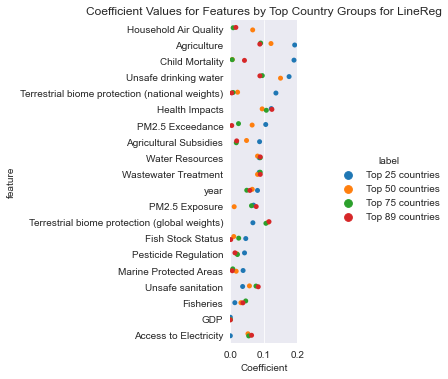

In [14]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_top, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for LineReg')
plt.xlabel('Coefficient')
plt.xlim(0,.2);

In [15]:
catplot_df_lasso_top=create_catplot_df(value_list,top_countries_df_lr,top='Top', model='lasso_coef')

''

<Figure size 576x864 with 0 Axes>

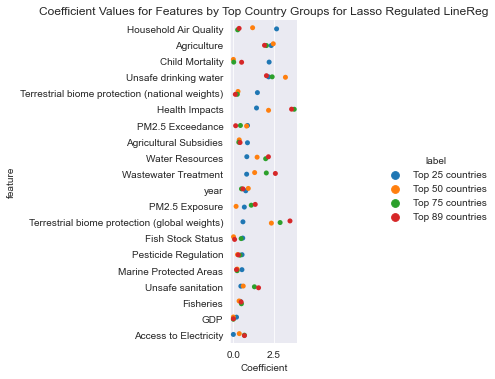

In [16]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lasso_top, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Lasso Regulated LineReg')
plt.xlabel('Coefficient')
;

In [17]:
catplot_df_ridge_top=create_catplot_df(value_list,top_countries_df_lr,top='Top', model='ridge_coef')

<Figure size 576x864 with 0 Axes>

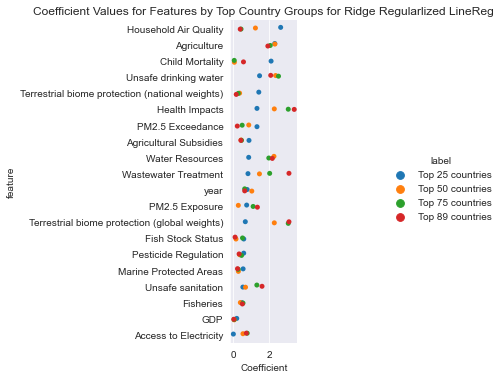

In [18]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_ridge_top, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Ridge Regularlized LineReg')
plt.xlabel('Coefficient');

repeating the same process for the bottom countries by EPI performance. 

In [19]:
bot_lrdf_list = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df, 'country_name', 'Environmental Performance Index',top=False)    
    bot_lrdf_list.append(a)
    bot_lrdf_list.append(b)
    bot_lrdf_list.append(c)

basic line reg scores: train:0.8606041008070284
basic line reg scores: test:0.8595296857024323
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8594997721550421
lasso line reg scores: test:0.8653023089513517
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8595035542271364
ridge line reg scores: test:0.8657230883890634
basic line reg scores: train:0.819469212085264
basic line reg scores: test:0.7872904962378657
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8192660944551404
lasso line reg scores: test:0.7881463567302338
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8188289163517588
ridge line reg scores: test:0.7880136478893423
basic line reg scores: train:0.8477949240990064
basic line reg scores: test:0.8484801596228363
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line 

In [20]:
bot_countries_df_lr= pd.DataFrame()
for i in bot_lrdf_list:
    bot_countries_df_lr[i.columns[0]] = i.iloc[:,0]
    bot_countries_df_lr[i.columns[1]] = i.iloc[:,1]

In [21]:
catplot_df_lr_bot = create_catplot_df(value_list,bot_countries_df_lr,top='Bot')

<Figure size 576x864 with 0 Axes>

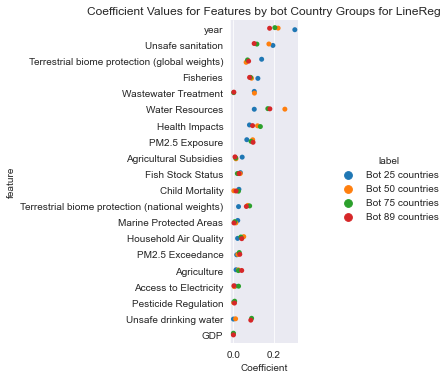

In [22]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_bot, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for LineReg')
plt.xlabel('Coefficient');

<Figure size 576x864 with 0 Axes>

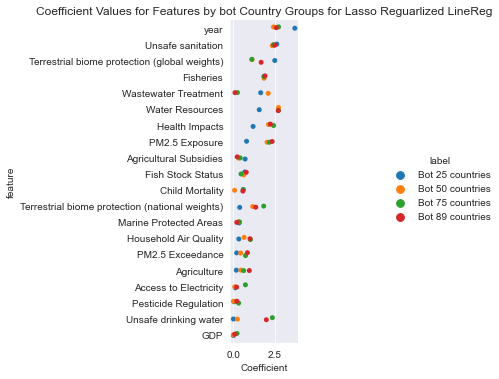

In [23]:
catplot_df_lasso_bot = create_catplot_df(value_list,bot_countries_df_lr,top='Bot', model='lasso_coef')
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lasso_bot, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Lasso Reguarlized LineReg')
plt.xlabel('Coefficient')
plt.show();

In [24]:
catplot_df_ridge_bot = create_catplot_df(value_list,bot_countries_df_lr,top='Bot', model='ridge_coef')

<Figure size 576x864 with 0 Axes>

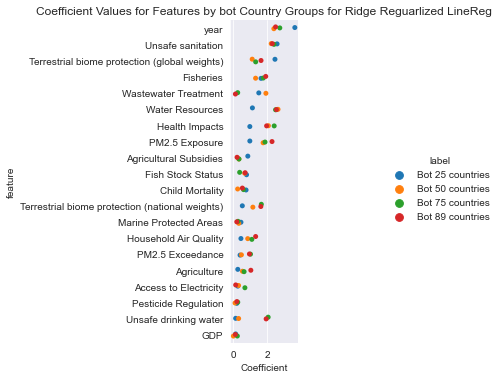

In [25]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_ridge_bot, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Ridge Reguarlized LineReg')
plt.xlabel('Coefficient')
plt.show();

making graphics for top and bottom combined:
decided to use Ridge models as they generally performed the best for their metrics. 

In [26]:
#defining some new data frams to use for graphing 
ridge_top_bot = pd.concat([catplot_df_ridge_top, catplot_df_ridge_bot], axis=0, ignore_index=True)
ridge_top_bot_50 = ridge_top_bot[(ridge_top_bot['label'] == 'Top 50 countries') | (ridge_top_bot['label'] == 'Bot 50 countries')]
ridge_top_bot_75 = ridge_top_bot[(ridge_top_bot['label'] == 'Top 75 countries') | (ridge_top_bot['label'] == 'Bot 75 countries')]

<Figure size 576x864 with 0 Axes>

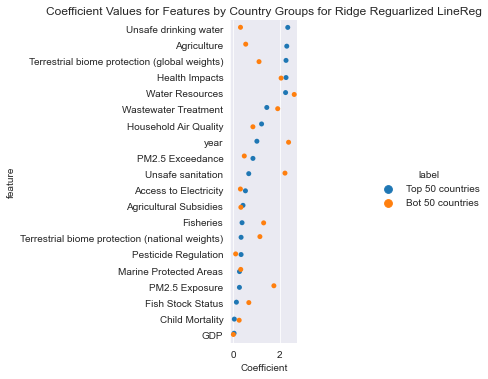

In [27]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_50, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Country Groups for Ridge Reguarlized LineReg')
plt.xlabel('Coefficient')
plt.show();

<Figure size 576x864 with 0 Axes>

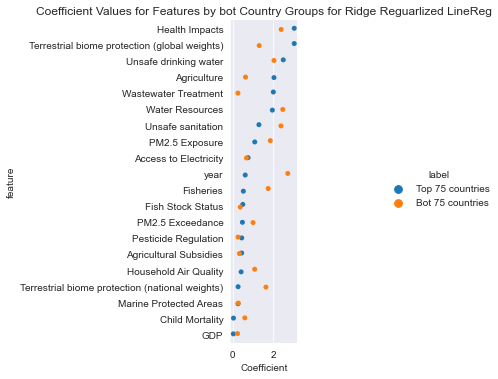

In [28]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_75, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Ridge Reguarlized LineReg')
plt.xlabel('Coefficient')
plt.show();

In [29]:
# thanks to: https://stackoverflow.com/a/39500357 user gabra

blue_patch = mpatches.Patch(color='Blue', label='Top Countries by Epi')
orange_patch = mpatches.Patch(color='Orange', label='Bot Countries by Epi')

<Figure size 1080x1440 with 0 Axes>

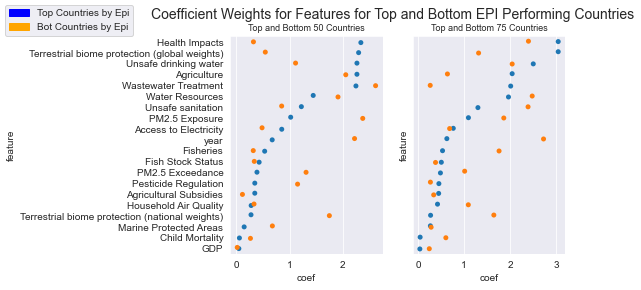

In [30]:
plt.figure(figsize=(15,20))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Coefficient Weights for Features for Top and Bottom EPI Performing Countries', size = 14)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=ridge_top_bot_50, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=ridge_top_bot_75, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

# Now lest look at pre and post 2015:

There were changes to the way the EPI was calculated in the year 2015, lets take a look at the impact of features both pre, and post these calucation changes. 

pre 2015:
process is the same as before, just with redfined data frames. 

In [31]:
df_pre15 = df[df['year'] < 2015].copy()

In [32]:
value_list = [50,75,89] #redefining values to not use 25, as it doesnt work as well with less data
top_lrdf_list_pre15 = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df_pre15, 'country_name', 'Environmental Performance Index')
    top_lrdf_list_pre15.append(a)
    top_lrdf_list_pre15.append(b)
    top_lrdf_list_pre15.append(c)

basic line reg scores: train:0.8827579098312965
basic line reg scores: test:0.8710259407817762
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8827454015625339
lasso line reg scores: test:0.8710451874651031
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8827419793336804
ridge line reg scores: test:0.8710997846253992
basic line reg scores: train:0.9141433977279725
basic line reg scores: test:0.8819339409864477
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.913877266802875
lasso line reg scores: test:0.8829545221417812
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.9139042103069658
ridge line reg scores: test:0.8831952785430185
basic line reg scores: train:0.9155739614219833
basic line reg scores: test:0.9124301375642552
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line 

In [33]:
top_countries_df_lr_pre15= pd.DataFrame()
for i in top_lrdf_list_pre15:
    top_countries_df_lr_pre15[i.columns[0]] = i.iloc[:,0]
    top_countries_df_lr_pre15[i.columns[1]] = i.iloc[:,1]

In [34]:
catplot_df_lr_top_pre15=create_catplot_df(value_list,top_countries_df_lr_pre15)

<Figure size 576x864 with 0 Axes>

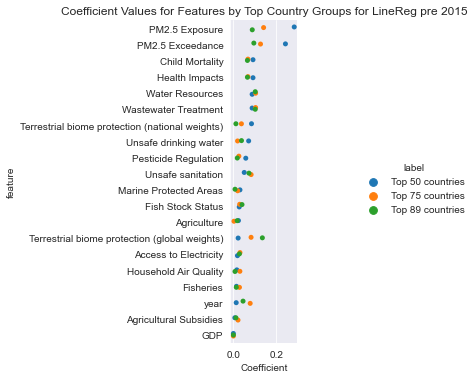

In [35]:
#had to not use the 25 countries one for this image, it warped the scale too much. 
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_top_pre15[catplot_df_lr_top_pre15['label']!= 'Top 25 countries'], x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for LineReg pre 2015')
plt.xlabel('Coefficient');


In [36]:
catplot_df_lasso_top_pre15=create_catplot_df(value_list,top_countries_df_lr_pre15,top='Top', model='lasso_coef')

<Figure size 576x864 with 0 Axes>

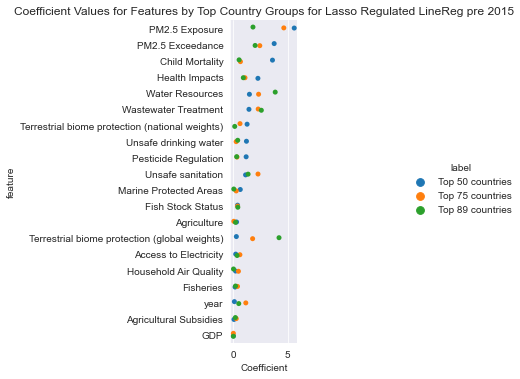

In [37]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lasso_top_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Lasso Regulated LineReg pre 2015')
plt.xlabel('Coefficient');

In [38]:
catplot_df_ridge_top_pre15=create_catplot_df(value_list,top_countries_df_lr_pre15,top='Top', model='ridge_coef')

''

<Figure size 576x864 with 0 Axes>

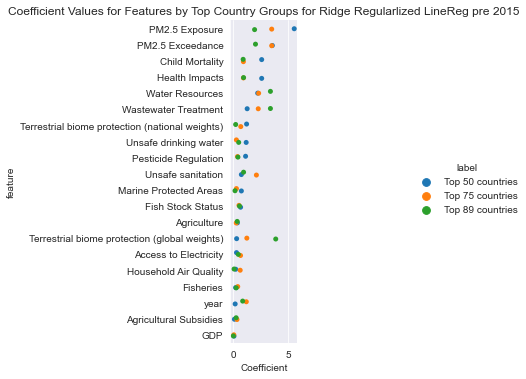

In [39]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_ridge_top_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Ridge Regularlized LineReg pre 2015')
plt.xlabel('Coefficient')
;

bottom countries pre 2015:

In [40]:

bot_lrdf_list_pre15 = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df_pre15, 'country_name', 'Environmental Performance Index',top=False)    
    bot_lrdf_list_pre15.append(a)
    bot_lrdf_list_pre15.append(b)
    bot_lrdf_list_pre15.append(c)

basic line reg scores: train:0.8087026263410062
basic line reg scores: test:0.7781819281411351
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8086932775518624
lasso line reg scores: test:0.7778893424861171
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8087005355772183
ridge line reg scores: test:0.7779962301883214
basic line reg scores: train:0.8554091774275835
basic line reg scores: test:0.8213321826933121
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8553503105598769
lasso line reg scores: test:0.8208019692066165
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8553348777167734
ridge line reg scores: test:0.820921507767694
basic line reg scores: train:0.8443703184880579
basic line reg scores: test:0.8557042518207524
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line 

In [41]:
bot_countries_df_lr_pre15= pd.DataFrame()
for i in bot_lrdf_list_pre15:
    bot_countries_df_lr_pre15[i.columns[0]] = i.iloc[:,0]
    bot_countries_df_lr_pre15[i.columns[1]] = i.iloc[:,1]

In [42]:
catplot_df_lr_bot = create_catplot_df(value_list,bot_countries_df_lr,top='Bot')

''

<Figure size 576x864 with 0 Axes>

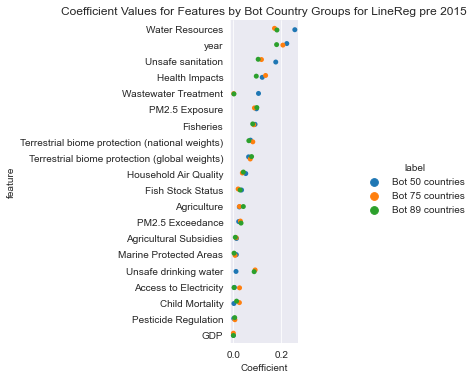

In [43]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_bot, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Bot Country Groups for LineReg pre 2015')
plt.xlabel('Coefficient')
;

<Figure size 576x864 with 0 Axes>

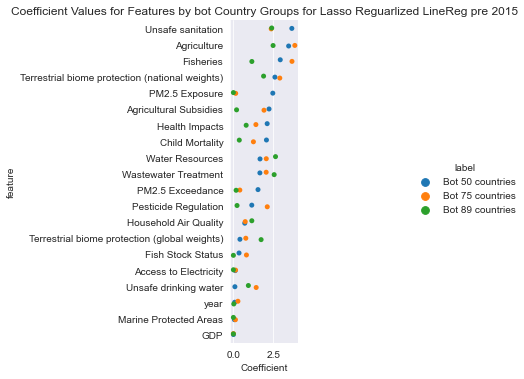

In [44]:
catplot_df_lasso_bot_pre15 = create_catplot_df(value_list,bot_countries_df_lr_pre15,top='Bot', model='lasso_coef')
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lasso_bot_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Lasso Reguarlized LineReg pre 2015')
plt.xlabel('Coefficient')
plt.show();

<Figure size 576x864 with 0 Axes>

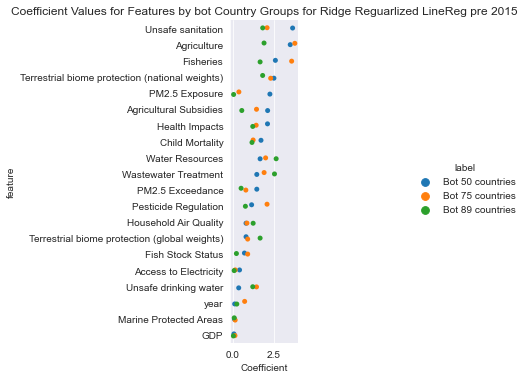

In [45]:
catplot_df_ridge_bot_pre15 = create_catplot_df(value_list,bot_countries_df_lr_pre15,top='Bot', model='ridge_coef')
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_ridge_bot_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Ridge Reguarlized LineReg pre 2015')
plt.xlabel('Coefficient')
plt.show();

making graphics for top and bottom combined pre 2015: 

In [46]:
ridge_top_bot_pre15 = pd.concat([catplot_df_ridge_top_pre15, catplot_df_ridge_bot_pre15], axis=0, ignore_index=True)
ridge_top_bot_50_pre15 = ridge_top_bot_pre15[(ridge_top_bot_pre15['label'] == 'Top 50 countries') | (ridge_top_bot_pre15['label'] == 'Bot 50 countries')]
ridge_top_bot_75_pre15 = ridge_top_bot_pre15[(ridge_top_bot_pre15['label'] == 'Top 75 countries') | (ridge_top_bot_pre15['label'] == 'Bot 75 countries')]

<Figure size 576x864 with 0 Axes>

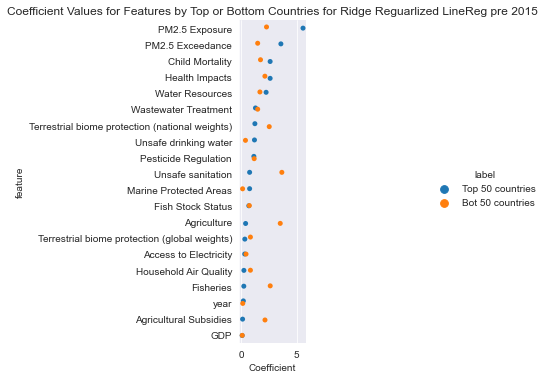

In [47]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_50_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top or Bottom Countries for Ridge Reguarlized LineReg pre 2015')
plt.xlabel('Coefficient')
plt.show();

<Figure size 576x864 with 0 Axes>

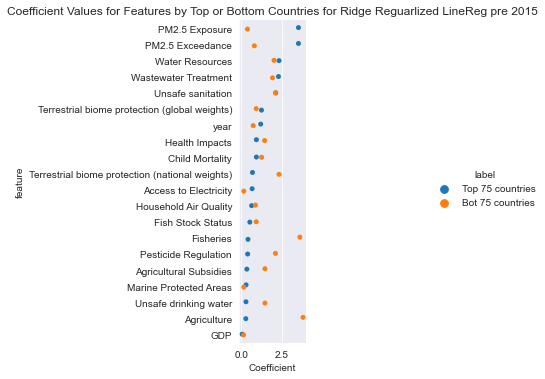

In [48]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_75_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top or Bottom Countries for Ridge Reguarlized LineReg pre 2015')
plt.xlabel('Coefficient')
plt.show();

In [49]:
# thanks to: https://stackoverflow.com/a/39500357 user gabra
blue_patch = mpatches.Patch(color='Blue', label='Top Countries by Epi')
orange_patch = mpatches.Patch(color='Orange', label='Bot Countries by Epi')

<Figure size 1080x1440 with 0 Axes>

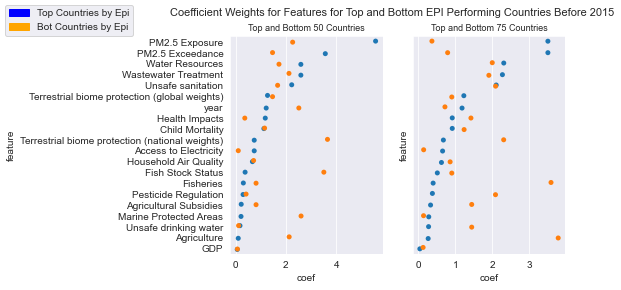

In [50]:
plt.figure(figsize=(15,20))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Coefficient Weights for Features for Top and Bottom EPI Performing Countries Before 2015', size = 11)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=ridge_top_bot_50_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=ridge_top_bot_75_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

post 2015

In [51]:
df_post15 = df[df['year'] >= 2015].copy()

In [52]:
top_lrdf_list_post15 = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df_post15, 'country_name', 'Environmental Performance Index')
    top_lrdf_list_post15.append(a)
    top_lrdf_list_post15.append(b)
    top_lrdf_list_post15.append(c)

basic line reg scores: train:0.8957270539616953
basic line reg scores: test:0.8726762581795571
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.895526573365818
lasso line reg scores: test:0.873190372867931
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8957264982299207
ridge line reg scores: test:0.8726853775305489
basic line reg scores: train:0.8961117422439223
basic line reg scores: test:0.8990147387306359
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8935450888334354
lasso line reg scores: test:0.8951141698865853
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.894398567307814
ridge line reg scores: test:0.8992490668500107
basic line reg scores: train:0.9104521656809992
basic line reg scores: test:0.8862571397192496
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line re

In [53]:
top_countries_df_lr_post15= pd.DataFrame()
for i in top_lrdf_list_post15:
    top_countries_df_lr_post15[i.columns[0]] = i.iloc[:,0]
    top_countries_df_lr_post15[i.columns[1]] = i.iloc[:,1]

In [54]:
catplot_df_lr_top_post15=create_catplot_df(value_list,top_countries_df_lr_post15)

<Figure size 576x864 with 0 Axes>

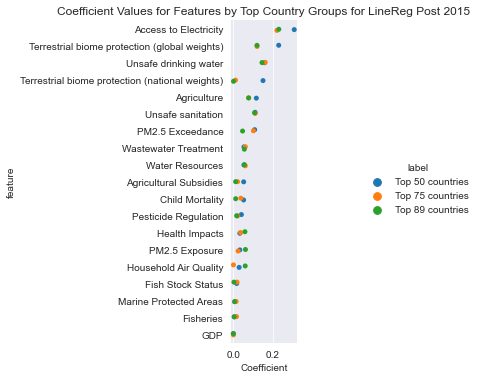

In [55]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_top_post15[catplot_df_lr_top_post15['feature']!='year'], x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for LineReg Post 2015')
plt.xlabel('Coefficient');

In [56]:
catplot_df_lasso_top_post15=create_catplot_df(value_list,top_countries_df_lr_post15,top='Top', model='lasso_coef')

<Figure size 576x864 with 0 Axes>

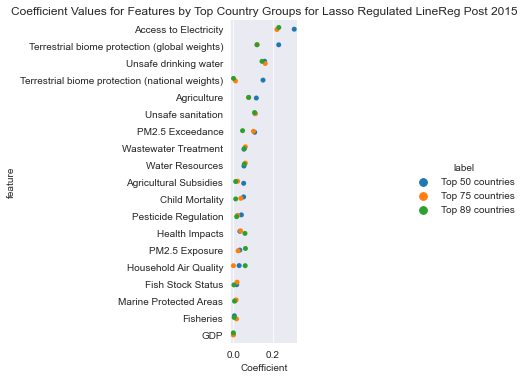

In [57]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_top_post15[catplot_df_lr_top_post15['feature']!='year'], x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Lasso Regulated LineReg Post 2015')
plt.xlabel('Coefficient');

In [58]:
catplot_df_ridge_top_post15=create_catplot_df(value_list,top_countries_df_lr_post15,top='Top', model='ridge_coef')

<Figure size 576x864 with 0 Axes>

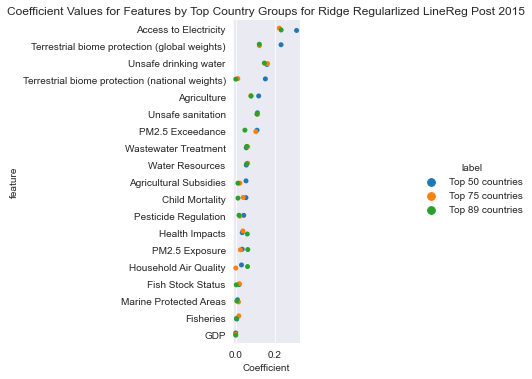

In [59]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_top_post15[catplot_df_lr_top_post15['feature']!='year'], x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top Country Groups for Ridge Regularlized LineReg Post 2015')
plt.xlabel('Coefficient');

bottom countries post 2015

In [60]:
bot_lrdf_list_post15 = []
for value in value_list:
    a, b, c = lr_coef_value = quick_regressions(value, df_post15, 'country_name', 'Environmental Performance Index',top=False)    
    bot_lrdf_list_post15.append(a)
    bot_lrdf_list_post15.append(b)
    bot_lrdf_list_post15.append(c)

basic line reg scores: train:0.8448740111189637
basic line reg scores: test:0.7630591536337783
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8436737418385573
lasso line reg scores: test:0.7643998039087694
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8434385640591034
ridge line reg scores: test:0.7670721418388862
basic line reg scores: train:0.8620421342130887
basic line reg scores: test:0.8627481108743839
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line reg scores: train:0.8598492891240277
lasso line reg scores: test:0.8625544820912563
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
ridge line reg scores: train:0.8606782407769124
ridge line reg scores: test:0.8612698161240382
basic line reg scores: train:0.8825100975473402
basic line reg scores: test:0.803646069205221
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
lasso line 

In [61]:
bot_countries_df_lr_post15= pd.DataFrame()
for i in bot_lrdf_list_post15:
    bot_countries_df_lr_post15[i.columns[0]] = i.iloc[:,0]
    bot_countries_df_lr_post15[i.columns[1]] = i.iloc[:,1]

In [62]:
catplot_df_lr_bot_post15 = create_catplot_df(value_list,bot_countries_df_lr_post15,top='Bot')

<Figure size 576x864 with 0 Axes>

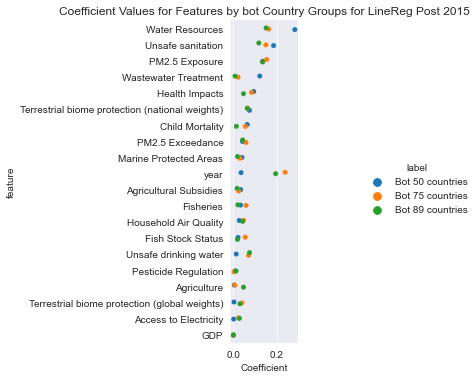

In [63]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lr_bot_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for LineReg Post 2015')
plt.xlabel('Coefficient');

<Figure size 576x864 with 0 Axes>

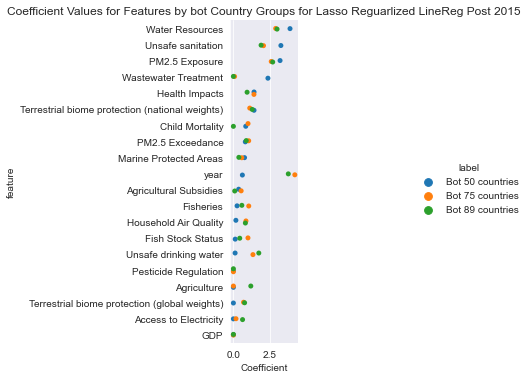

In [64]:
catplot_df_lasso_bot_post15 = create_catplot_df(value_list,bot_countries_df_lr_post15,top='Bot', model='lasso_coef')
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_lasso_bot_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Lasso Reguarlized LineReg Post 2015')
plt.xlabel('Coefficient')
plt.show();

<Figure size 576x864 with 0 Axes>

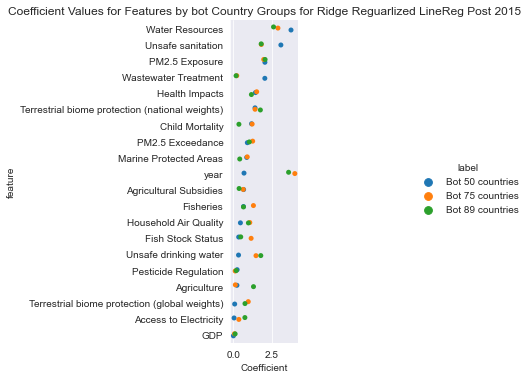

In [65]:
catplot_df_ridge_bot_post15 = create_catplot_df(value_list,bot_countries_df_lr_post15,top='Bot', model='ridge_coef')
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_df_ridge_bot_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by bot Country Groups for Ridge Reguarlized LineReg Post 2015')
plt.xlabel('Coefficient')
plt.show();

making graphics for top and bottom combined: 

In [66]:
ridge_top_bot_post15 = pd.concat([catplot_df_ridge_top_post15, catplot_df_ridge_bot_post15], axis=0, ignore_index=True)
ridge_top_bot_50_post15 = ridge_top_bot_post15[(ridge_top_bot_post15['label'] == 'Top 50 countries') | (ridge_top_bot_post15['label'] == 'Bot 50 countries')]
ridge_top_bot_75_post15 = ridge_top_bot_post15[(ridge_top_bot_post15['label'] == 'Top 75 countries') | (ridge_top_bot_post15['label'] == 'Bot 75 countries')]

<Figure size 576x864 with 0 Axes>

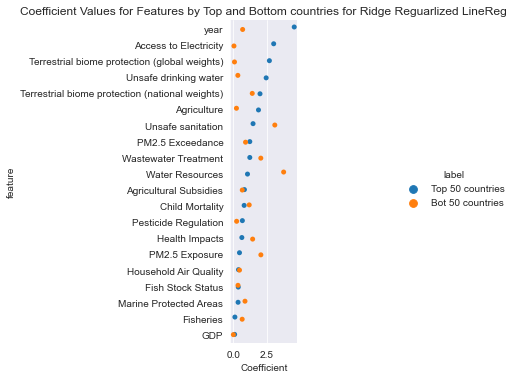

In [67]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_50_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top and Bottom countries for Ridge Reguarlized LineReg')
plt.xlabel('Coefficient')
plt.show();

<Figure size 576x864 with 0 Axes>

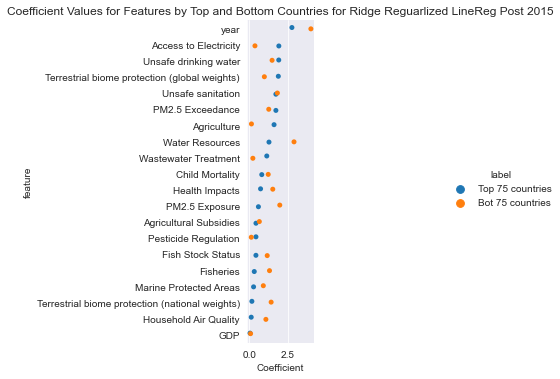

In [68]:
plt.figure(figsize=(8,12))
sns.catplot(data=ridge_top_bot_75_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Coefficient Values for Features by Top and Bottom Countries for Ridge Reguarlized LineReg Post 2015')
plt.xlabel('Coefficient')
plt.show();

<Figure size 1080x1440 with 0 Axes>

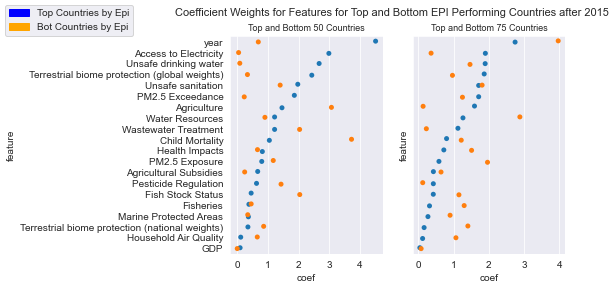

In [69]:
plt.figure(figsize=(15,20))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Coefficient Weights for Features for Top and Bottom EPI Performing Countries after 2015', size = 11)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=ridge_top_bot_50_post15, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=ridge_top_bot_75_post15, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

other two graphs just for quick comparison:

<Figure size 1080x1440 with 0 Axes>

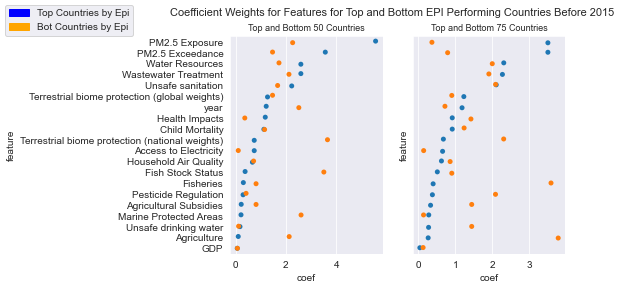

In [70]:
plt.figure(figsize=(15,20))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Coefficient Weights for Features for Top and Bottom EPI Performing Countries Before 2015', size = 11)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=ridge_top_bot_50_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=ridge_top_bot_75_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

<Figure size 1080x1440 with 0 Axes>

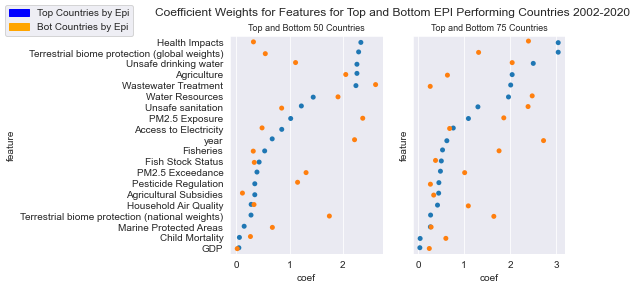

In [71]:
plt.figure(figsize=(15,20))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Coefficient Weights for Features for Top and Bottom EPI Performing Countries 2002-2020', size = 12)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=ridge_top_bot_50, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=ridge_top_bot_75, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

extra trees

all years

In [72]:
def extra_trees(size, dataframe, column, target, top=True):
    if top:
        func_list = country_list(size, top=True)
        func_df = dataframe[dataframe[column].isin(func_list)]
    if not top:
        func_list = country_list(size, top=False)
        func_df = dataframe[dataframe[column].isin(func_list)]
        
    X = func_df.drop(columns=drop_list)
    y = func_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
    
    et = ExtraTreesRegressor(random_state = 42, bootstrap = True)
    
    et_pipe_params = {'n_estimators': list(range(10,100,2)),
            'min_samples_split': uniform(0, .1),
            'min_samples_leaf': uniform(0, .1),
            'min_weight_fraction_leaf': loguniform(0.0001, .2),
            'min_impurity_decrease': loguniform(0.0001, .1),
            'min_impurity_split': loguniform(0.0001, .1),
            'ccp_alpha': loguniform(0.000001, .1),
            'max_samples': uniform(.8, 1)}
                   
    et_rs = RandomizedSearchCV(et, param_distributions = et_pipe_params, 
    cv = 5, n_jobs = -2, n_iter=1000, random_state = 42)

    et_rs.fit(X_train, y_train)
    
    print(f'{value} train: {et_rs.score(X_train,y_train)}')
    print(f'{value} test: {et_rs.score(X_test,y_test)}')  
    dtree_estimators = pd.DataFrame(zip(et_rs.best_estimator_.feature_importances_, X.columns), columns=[f'{size} estimator', f'{size} feature'])
    dtree_estimators.sort_values(f'{size} estimator',ascending=False, inplace=True)
    dtree_estimators.reset_index(inplace=True,drop=True)

    return dtree_estimators

In [73]:
#%%capture
value_list = [25,50,75,89]
top_et_list = []
for value in value_list:
    a = extra_trees(value, df, 'country_name', 'Environmental Performance Index')
    top_et_list.append(a)

25 train: 0.9405671681575389
25 test: 0.8623222403815844
50 train: 0.962457713992442
50 test: 0.9367449233600724
75 train: 0.9651728903275344
75 test: 0.9430287984458006
89 train: 0.9677629861146588
89 test: 0.9545957276433795


In [74]:
top_countries_et_df= pd.DataFrame()
for i in top_et_list:
    top_countries_et_df[i.columns[0]] = i.iloc[:,0]
    top_countries_et_df[i.columns[1]] = i.iloc[:,1]

In [75]:
bot_et_list = []
for value in value_list:
    a = extra_trees(value, df, 'country_name', 'Environmental Performance Index', top=False)
    bot_et_list.append(a)

25 train: 0.9703894401567946
25 test: 0.9250539195415606
50 train: 0.9623976796527978
50 test: 0.9397620347817564
75 train: 0.953816191347257
75 test: 0.9273030504445919
89 train: 0.9602388326447229
89 test: 0.9386743535496441


In [76]:
bot_countries_et_df= pd.DataFrame()
for i in bot_et_list:
    bot_countries_et_df[i.columns[0]] = i.iloc[:,0]
    bot_countries_et_df[i.columns[1]] = i.iloc[:,1]

In [77]:
catplot_top_et = create_catplot_df(value_list, top_countries_et_df, model="estimator")

FileNotFoundError: [Errno 2] No such file or directory: './images/CountryExtraTrees/Feature_Importance_Top_groups.png'

<Figure size 576x864 with 0 Axes>

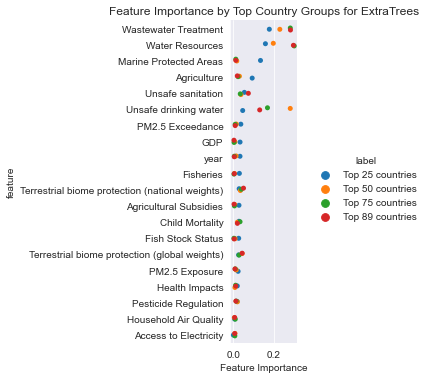

In [78]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Top Country Groups for ExtraTrees')
plt.xlabel('Feature Importance');
plt.savefig('./images/CountryExtraTrees/Feature_Importance_Top_groups')

In [ ]:
catplot_bot_et = create_catplot_df(value_list, bot_countries_et_df, model="estimator", top='Bot')

In [ ]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Bot Country Groups for ExtraTrees')
plt.xlabel('Feature Importance');

In [ ]:
et_top_bot = pd.concat([catplot_top_et, catplot_bot_et], axis=0, ignore_index=True)
et_top_bot_50 = et_top_bot[(et_top_bot['label'] == 'Top 50 countries') | (et_top_bot['label'] == 'Bot 50 countries')]
et_top_bot_75 = et_top_bot[(et_top_bot['label'] == 'Top 75 countries') | (et_top_bot['label'] == 'Bot 75 countries')]

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_50, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_75, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(20,15))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Feature Importances for Top and Bottom EPI Performing Countries', size = 14)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=et_top_bot_50, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=et_top_bot_75, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

In [ ]:
def make_differences_df(top_bot_df, value, join_on = 'feature'):
    temp_top = top_bot_df[top_bot_df['label'] == f'Top {value} countries'].sort_values(join_on)
    temp_bot = top_bot_df[top_bot_df['label'] == f'Bot {value} countries'].sort_values(join_on)
    
    temp_top.set_index(join_on, inplace=True)
    temp_bot.set_index(join_on, inplace=True)
    
    output_df = pd.concat([temp_top,temp_bot], axis=1, ignore_index=True)
    output_df.reset_index(inplace=True)
    output_df.rename(columns={0:'top importance',1:'top label',2:'bot importance',3:'bot label'},inplace=True)
    output_df['differences'] = output_df['top importance'] - output_df['bot importance']
    output_df.sort_values('differences', inplace=True, ascending=False)
    return output_df
    

In [ ]:
overall = make_differences_df(et_top_bot_75,75)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=overall,
           x='differences',
           y='feature')
plt.title('Comparative Feature Importance for Top 76 vs Bot 75 Countries');

Pre 2015

In [ ]:
df_pre15 = df[df['year'] < 2015].copy()

In [ ]:
value_list = [25,50,75,89]
top_et_list_pre15 = []
for value in value_list:
    a = extra_trees(value, df_pre15, 'country_name', 'Environmental Performance Index')
    top_et_list_pre15.append(a)

In [ ]:
top_countries_et_df_pre15= pd.DataFrame()
for i in top_et_list_pre15:
    top_countries_et_df_pre15[i.columns[0]] = i.iloc[:,0]
    top_countries_et_df_pre15[i.columns[1]] = i.iloc[:,1]

In [ ]:
bot_et_list_pre15 = []
for value in value_list:
    a = extra_trees(value, df_pre15, 'country_name', 'Environmental Performance Index', top=False)
    bot_et_list_pre15.append(a)

In [ ]:
bot_countries_et_df_pre15= pd.DataFrame()
for i in bot_et_list_pre15:
    bot_countries_et_df_pre15[i.columns[0]] = i.iloc[:,0]
    bot_countries_et_df_pre15[i.columns[1]] = i.iloc[:,1]

In [ ]:
catplot_top_et_pre15 = create_catplot_df(value_list, top_countries_et_df_pre15, model="estimator")

In [ ]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Top Country Groups for ExtraTrees pre 2015')
plt.xlabel('Feature Importance');
#plt.savefig('./images/CountryCoefCatplots/Coefs_top_LineReg.png', bbox_inches='tight')

In [ ]:
catplot_bot_et_pre15 = create_catplot_df(value_list, bot_countries_et_df_pre15, model="estimator", top='Bot')

In [ ]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Bot Country Groups for ExtraTrees pre 2015')
plt.xlabel('Feature Importance');

In [ ]:
et_top_bot_pre15 = pd.concat([catplot_top_et_pre15, catplot_bot_et_pre15], axis=0, ignore_index=True)
et_top_bot_50_pre15 = et_top_bot_pre15[(et_top_bot_pre15['label'] == 'Top 50 countries') | (et_top_bot_pre15['label'] == 'Bot 50 countries')]
et_top_bot_75_pre15 = et_top_bot_pre15[(et_top_bot_pre15['label'] == 'Top 75 countries') | (et_top_bot_pre15['label'] == 'Bot 75 countries')]

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_50_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees pre 2015')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_75_pre15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees pre 2015')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(20,15))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Feature Importances for Top and Bottom EPI Performing Countries pre 2015', size = 14)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=et_top_bot_50_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=et_top_bot_75_pre15, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

In [ ]:
overall_pre15 = make_differences_df(et_top_bot_75_pre15,75)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=overall_pre15,
           x='differences',
           y='feature')
plt.title('Comparative Feature Importance for Top 75 vs Bot 75 Countries pre 2015');

post 2015 data

In [ ]:
df_post15 = df[df['year'] >= 2015].copy()

In [ ]:

value_list = [25,50,75,89]
top_et_list_post15 = []
for value in value_list:
    a = extra_trees(value, df_post15, 'country_name', 'Environmental Performance Index')
    top_et_list_post15.append(a)

In [ ]:
top_countries_et_df_post15= pd.DataFrame()
for i in top_et_list_post15:
    top_countries_et_df_post15[i.columns[0]] = i.iloc[:,0]
    top_countries_et_df_post15[i.columns[1]] = i.iloc[:,1]

In [ ]:

bot_et_list_post15 = []
for value in value_list:
    a = extra_trees(value, df_post15, 'country_name', 'Environmental Performance Index', top=False)
    bot_et_list_post15.append(a)

In [ ]:
bot_countries_et_df_post15= pd.DataFrame()
for i in bot_et_list_post15:
    bot_countries_et_df_post15[i.columns[0]] = i.iloc[:,0]
    bot_countries_et_df_post15[i.columns[1]] = i.iloc[:,1]

In [ ]:
catplot_top_et_post15 = create_catplot_df(value_list, top_countries_et_df_post15, model="estimator")

In [ ]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Top Country Groups for ExtraTrees post 2015')
plt.xlabel('Feature Importance');
#plt.savefig('./images/CountryCoefCatplots/Coefs_top_LineReg.png', bbox_inches='tight')

In [ ]:
catplot_bot_et_post15 = create_catplot_df(value_list, bot_countries_et_df_post15, model="estimator", top='Bot')

In [ ]:
plt.figure(figsize=(8,12))
sns.catplot(data=catplot_top_et_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importance by Bot Country Groups for ExtraTrees post 2015')
plt.xlabel('Feature Importance');

In [ ]:
et_top_bot_post15 = pd.concat([catplot_top_et_post15, catplot_bot_et_post15], axis=0, ignore_index=True)
et_top_bot_50_post15 = et_top_bot_post15[(et_top_bot_post15['label'] == 'Top 50 countries') | (et_top_bot_post15['label'] == 'Bot 50 countries')]
et_top_bot_75_post15 = et_top_bot_post15[(et_top_bot_post15['label'] == 'Top 75 countries') | (et_top_bot_post15['label'] == 'Bot 75 countries')]

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_50_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees post 2015')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(10,10))
sns.catplot(data=et_top_bot_75_post15, x='coef', y='feature', hue='label', orient='h')
plt.title('Feature Importances by Country Groups for Extra Trees post 2015')
plt.xlabel('Feature Importances');

In [ ]:
plt.figure(figsize=(20,15))
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True)
fig.suptitle('Feature Importances for Top and Bottom EPI Performing Countries post 2015', size = 14)
fig.legend(handles = [blue_patch,orange_patch], loc=2)
sns.stripplot(data=et_top_bot_50_post15, x='coef', y='feature', hue='label', orient='h', ax=ax1)
sns.stripplot(data=et_top_bot_75_post15, x='coef', y='feature', hue='label', orient='h', ax=ax2)
ax1.set_title('Top and Bottom 50 Countries', size=9)
ax2.set_title('Top and Bottom 75 Countries', size=9)
ax1.get_legend().remove()
ax2.get_legend().remove();

In [ ]:
overall_post15 = make_differences_df(et_top_bot_75_post15, 75)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data=overall_post15,
           x='differences',
           y='feature')
plt.title('Comparative Feature Importance for Top vs Bot Countries post 2015');